In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load Tail Angle

In [4]:
df = pd.read_hdf('Zebrafish.h5')

In [5]:
df.head(10)

x         y     theta  tail_angle_01  tail_angle_02  \
frame_id                                                               
305901    354.6027  762.4877  1.688693      -0.057569      -0.098585   
305902    354.7846  762.4101  1.679170      -0.049721      -0.110686   
305903    354.7972  762.2639  1.680839      -0.063216      -0.105089   
305904    354.9238  762.0828  1.677423      -0.060133      -0.113719   
305905    354.8554  762.4290  1.676634      -0.036935      -0.148548   
305906    354.9251  762.2833  1.676751      -0.025943      -0.151010   
305907    354.9701  762.2706  1.679253      -0.029676      -0.154981   
305908    355.0045  762.0753  1.681015      -0.049407      -0.124992   
305909    354.9362  762.7366  1.679855      -0.003576      -0.172042   
305910    354.9089  762.6892  1.683179      -0.021265      -0.109144   

          tail_angle_03  tail_angle_04  tail_angle_05  tail_angle_06  \
frame_id                                                               
305901         0.079641       0.049129      -0.082754      -0.128328   
305902         0.082935       0.060231      -0.066932      -0.100862   
305903         0.083205       0.053699      -0.052808      -0.083353   
305904         0.073875       0.065227      -0.009110      -0.101244   
305905         0.095650       0.001300       0.095087      -0.151557   
305906         0.034835       0.084802       0.017422      -0.076704   
305907         0.040370       0.071754       0.004252      -0.026808   
305908         0.026483       0.080777      -0.039683       0.034957   
305909        -0.014626       0.082224       0.014183       0.051321   
305910        -0.092486       0.054679       0.077161       0.003881   

          tail_angle_07  ...  tail_value_01  tail_value_02  tail_value_03  \
frame_id                 ...                                                
305901        -0.083319  ...       110.2709       107.3225       60.82891   
305902        -0.116938  ...       108.7593       118.9064       71.30074   
305903        -0.116282  ...       112.0417       119.4430       82.47068   
305904        -0.110419  ...       113.9246       124.5385       92.53473   
305905        -0.096062  ...       112.6283       113.8588       97.03622   
305906        -0.084571  ...       116.6183       113.7184       91.00258   
305907        -0.088701  ...       119.7308       112.0695       88.51680   
305908        -0.095538  ...       117.7122       113.0838       84.81815   
305909        -0.101861  ...       127.7499       123.9602       86.90324   
305910        -0.014184  ...       130.2539       107.3957       91.64360   

          tail_value_04  tail_value_05  tail_value_06  tail_value_07  \
frame_id                                                               
305901         90.88052       76.23203       51.16987       44.68130   
305902         84.24125       77.45908       48.44184       46.75766   
305903         82.50231       69.73067       52.13729       47.75901   
305904         83.81439       74.69270       54.38569       47.64020   
305905         96.01034       59.95189       62.38118       45.84756   
305906         97.86189       73.53310       51.08514       49.02306   
305907         88.31061       75.30571       53.76753       52.34233   
305908         80.49852       82.55347       57.28442       52.53932   
305909         71.24934       75.41571       52.09628       47.68031   
305910         72.87362       64.86969       65.13358       45.11681   

          tail_value_08  tail_value_09  tail_value_10  
frame_id                                               
305901         43.60098        0.00000            0.0  
305902         48.87668        3.97171            0.0  
305903         42.42837        0.00000            0.0  
305904         43.64951        0.00000            0.0  
305905         42.23901        0.00000            0.0  
305906         43.50781        0.00000            0.0  
305907         41.39820        0.00000           

In [6]:
from AllSegmentationClass import Tail

# use tail value as a mask:
NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])

tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
tail_angle = tail_angle.values

# Reshape tail angle if head restrained:
if tail_angle.shape[1]==16:
    from skimage.transform import resize
    tail_angle = resize(tail_angle, (tail_angle.shape[0], 10),order=0) # 0 for nearest neighbor

tail = Tail(tail_angle)
tail.tail_angle_preprocessing()

print('Shape of No Track:')
print(len(tail.notrack_id))

Shape of No Track:
11117


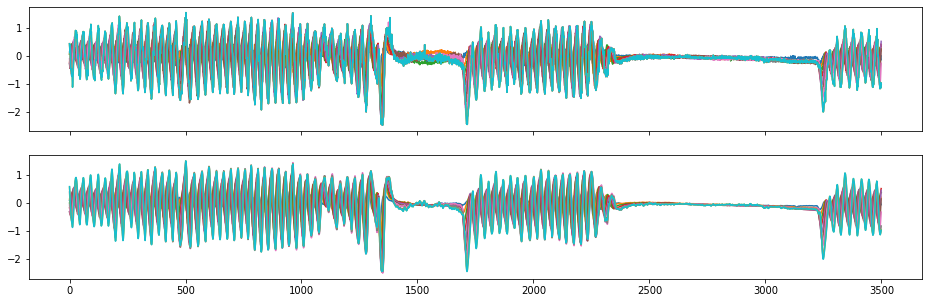

In [7]:
# Diagnostic Plot:
Duration = 700*5
IdSt = np.random.randint(tail.T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(16,5), sharex=True)
ax[0].plot(tail.angle[IdSt:IdSt+Duration,:])
ax[1].plot(tail.angle_smooth[IdSt:IdSt+Duration,:])
plt.show()

# Find when the tail is moving (coarse segmentation)

In [8]:
from AllSegmentationClass import Binarization

In [9]:
bin = Binarization(tail)

In [10]:
bin.compute_low_pass_speed(win_BC = 10,MinFiltSize=500,MaxFiltSize=20)
bin.compute_noiselevel(win_zscore = 30,win_smoothing = 7, win_med=51)

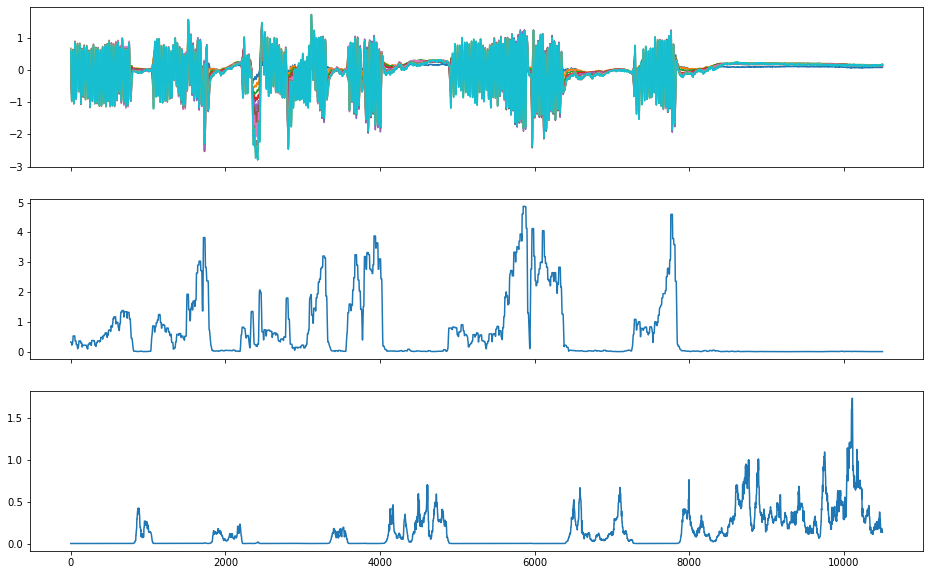

In [11]:
# Diagnostic Plot:
Duration = 700*15
IdSt = np.random.randint(tail.T-Duration)
fig, (ax) = plt.subplots(3,1,figsize=(16,10), sharex=True)
ax[0].plot(tail.angle_smooth[IdSt:IdSt+Duration,:])

ax[1].plot(bin.low_pass_speed[IdSt:IdSt+Duration])
ax[2].plot(bin.smooth_residual[IdSt:IdSt+Duration])

plt.show()

0.12059437681305943


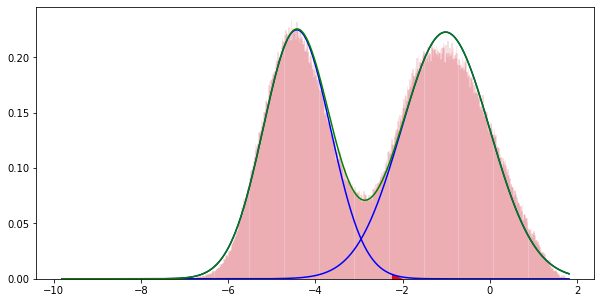

In [14]:
# Compute Threshold on speed:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
SpeedThresh,ax = bin.estimate_threshold_using_GMM(bin.low_pass_speed,margin_std = 3, axis=ax)
print(SpeedThresh)

0.026192151431048315


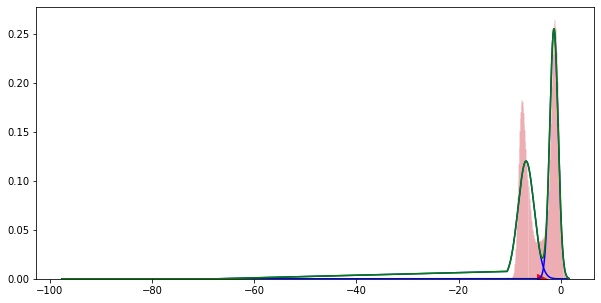

In [15]:
# Compute Threshold on noise:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
NoiseThresh,ax = bin.estimate_threshold_using_GMM(bin.smooth_residual,margin_std = 2, axis=ax)
print(NoiseThresh)

In [16]:
# Multiplicative Constrain: speed above SpeedThresh & noise below NoiseThresh 
tail_active1 = 1.0*(bin.low_pass_speed>SpeedThresh)#(bin.smooth_residual<NoiseThresh)
tail_active2 = 1.0*(bin.smooth_residual<NoiseThresh)
#np.logical_or(bin.smooth_residual>NoiseThresh,bin.low_pass_speed<SpeedThresh)
from AllSegmentationClass import find_onset_offset_numpy

tail_active = 1.0*((tail_active1+tail_active2)>0)
tail_active = tail_active1
onset,offset,duration = find_onset_offset_numpy(tail_active)

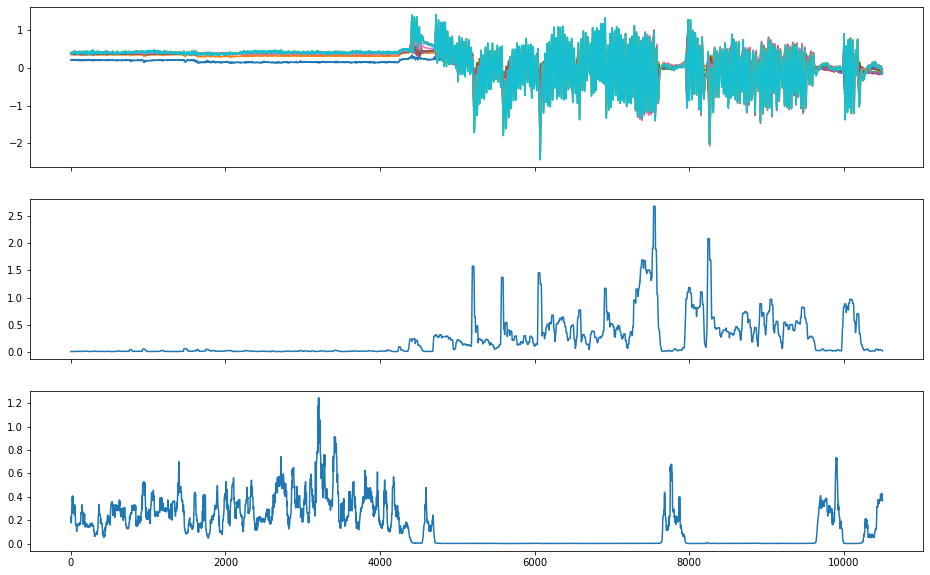

In [17]:

# Diagnostic Plot:
Duration = 700*15
IdSt = np.random.randint(tail.T-Duration)
fig, (ax) = plt.subplots(3,1,figsize=(16,10), sharex=True)
ax[0].plot(tail.angle_smooth[IdSt:IdSt+Duration,:])

ax[1].plot(bin.low_pass_speed[IdSt:IdSt+Duration])
ax[2].plot(bin.smooth_residual[IdSt:IdSt+Duration])

plt.show()

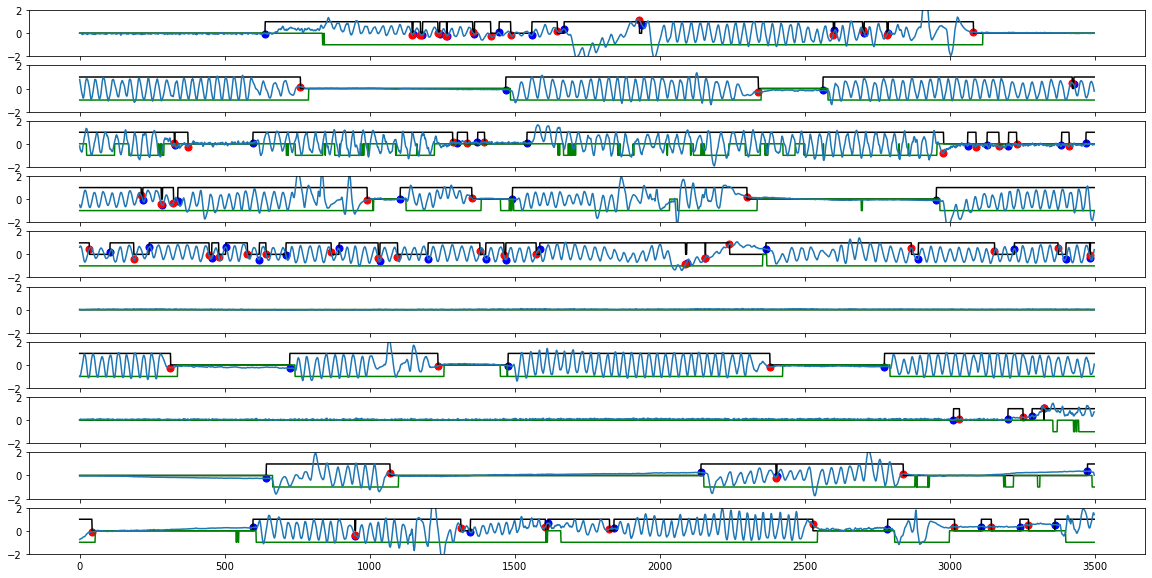

In [18]:
# Diagnostic Plot:
Duration = 700*5
s = tail.Reference_tail_segment_end
fig, (ax) = plt.subplots(10,1,figsize=(20,10), sharex=True)
for i in range(10):
    IdSt = np.random.randint(tail.T-Duration)
    ax[i].plot(tail_active1[IdSt:IdSt+Duration],'k')
    ax[i].plot(-tail_active2[IdSt:IdSt+Duration],'g')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='b')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='r')
    ax[i].plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
    ax[i].set_ylim(-2,2)
plt.show()

In [19]:
# Could be useful to add some cleanup to tail active:
# morphological opening to erode then dilate

# Finding Half Beat

In [20]:
from AllSegmentationClass import HalfBeat

In [21]:
HB = HalfBeat(tail_active,tail)

In [22]:
HB.find_slice(Min_Duration = 80,Min_IBI = 10)
HB.extract_half_beat(Half_BCFilt = 150, stdThres = 5,MinSizeBlob=400,Margin=10)

In [23]:
peaks_pos,peaks_neg = HB.half_beat_pos,HB.half_beat_neg

In [24]:
tail_active = HB.refine_bouts(MaxIBeatI = 40)
onset,offset,duration = find_onset_offset_numpy(tail_active)

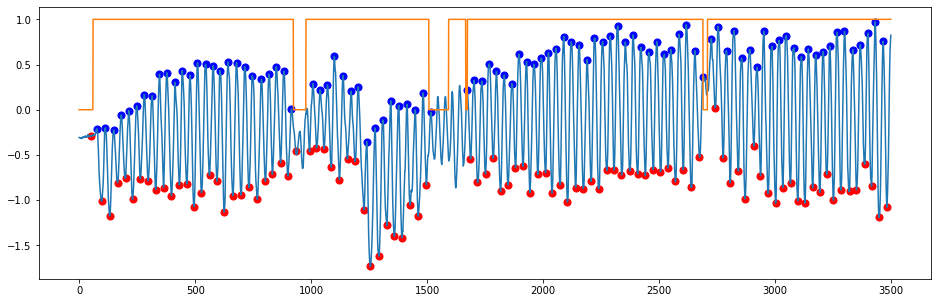

In [35]:
# Diagnostic Plot:
Duration = 700*5
IdSt = np.random.randint(tail.T-Duration)
s = tail.Reference_tail_segment_end

fig, (ax) = plt.subplots(1,1,figsize=(16,5), sharex=True)

id = peaks_pos[(peaks_pos>IdSt)&(peaks_pos<(IdSt+Duration))]-IdSt
ax.scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='b')

id = peaks_neg[(peaks_neg>IdSt)&(peaks_neg<(IdSt+Duration))]-IdSt
ax.scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='r')

ax.plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
ax.plot(HB.tail_active_in[IdSt:IdSt+Duration])

plt.show()

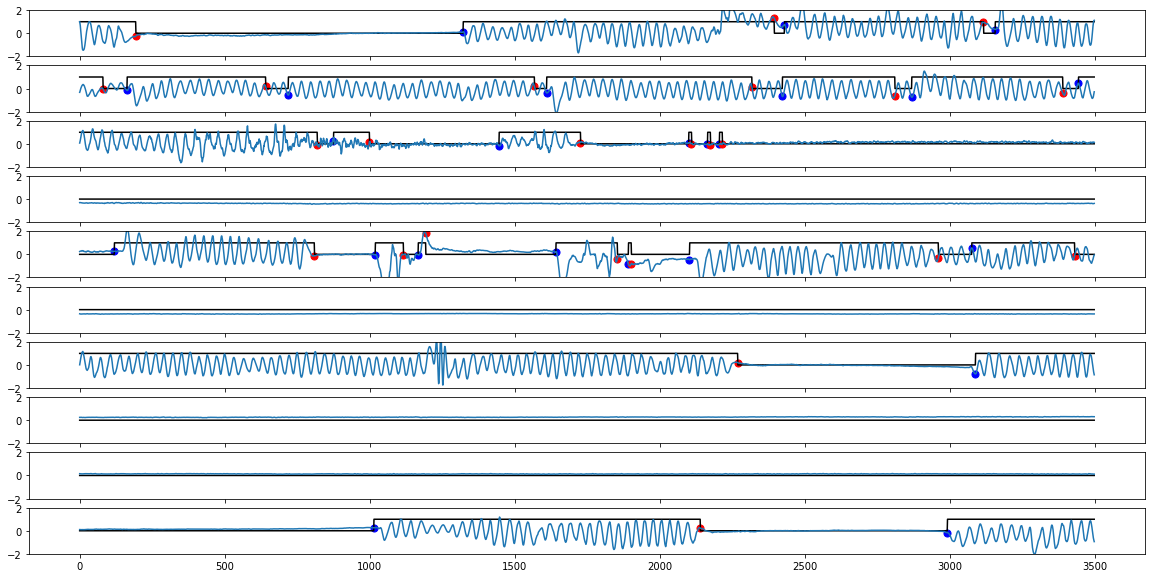

In [26]:
# Diagnostic Plot:
Duration = 700*5
s = tail.Reference_tail_segment_end
fig, (ax) = plt.subplots(10,1,figsize=(20,10), sharex=True)
for i in range(10):
    IdSt = np.random.randint(tail.T-Duration)
    ax[i].plot(tail_active[IdSt:IdSt+Duration],'k')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='b')
    id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
    if len(id)>0:
        ax[i].scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='r')
    ax[i].plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
    ax[i].set_ylim(-2,2)
plt.show()

# Identify Breakpoint to cut doublebouts

In [39]:
tail_signal = tail.angle_smooth[:700*60*30,tail.Reference_tail_segment_end]

all_peaks = np.concatenate((HB.half_beat_pos,HB.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks[all_peaks<tail_signal.shape[0]]


In [40]:
from AllSegmentationClass import BreakPoint

In [41]:
breakpoint = BreakPoint()
L=4
peaks,likelihood_ratio = breakpoint.evaluate_break_point(tail_signal,L,onset,offset,all_peaks,margin_time=[90,30],sigma=None,method='costafast')

In [42]:
likelihood_ratio.shape

(48,)

0.274622331854637
159.75211233793704


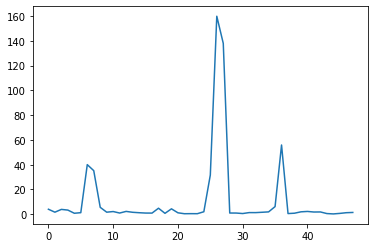

In [43]:
print(np.min(likelihood_ratio))
print(np.max(likelihood_ratio))
plt.plot(likelihood_ratio)
plt.show()

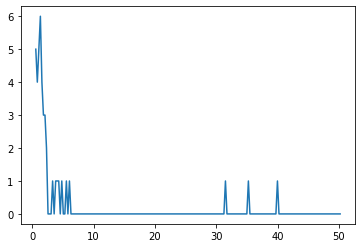

In [44]:
hist, bins = np.histogram(likelihood_ratio,range=(np.percentile(likelihood_ratio,5),np.percentile(likelihood_ratio,95)),bins = 200)
plt.plot(0.5*(bins[1:]+bins[0:-1]),hist)
plt.show()

In [45]:
print(np.percentile(likelihood_ratio,90))
Thresh = np.percentile(likelihood_ratio,90)

32.6936517329904


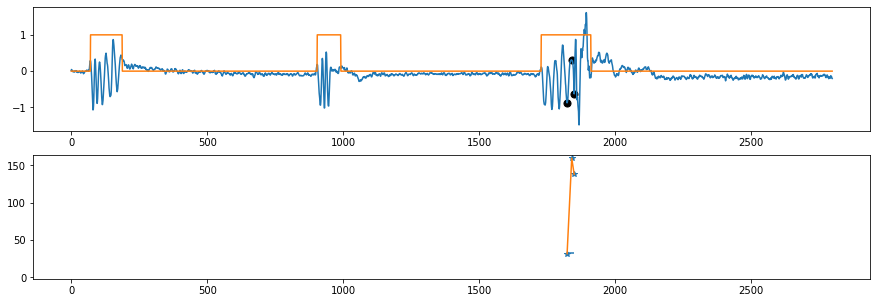

In [53]:
Duration = 700*4
while True:
    #IdSt = 2396873
    IdSt = 73262
    IdSt = np.random.randint(tail_signal.shape[0]-Duration)
    id = peaks[(peaks>IdSt)&(peaks<(IdSt+Duration))]-IdSt
    if len(id)>2:
        break

fig = plt.figure(figsize=(15,5))

s = tail.Reference_tail_segment_end
ax1 = plt.subplot(211)
ax1.plot(tail.angle_smooth[IdSt:IdSt+Duration,s])
ax1.plot(tail_active[IdSt:IdSt+Duration])

#on_,off_ = onset[(onset>IdSt)&(onset<IdSt+Duration)],offset[(offset>IdSt)&(offset<IdSt+Duration)]
#on_,off_ = on_-IdSt,off_-IdSt
ax1.scatter(id,tail.angle_smooth[IdSt:IdSt+Duration,s][id],s=50,c='k')
#ax1.scatter(on_,np.zeros_like(on_),s=20,c='b')
#ax1.scatter(off_,np.zeros_like(off_),s=20,c='r')

ax2 = plt.subplot(212, sharex = ax1)
l = likelihood_ratio[(peaks>IdSt)&(peaks<(IdSt+Duration))]
ax2.plot(id,l,'*')
#ax2.stem(id,l)
ax2.plot(id,l)
ax2.hlines(Thresh,id[0],id[-1])

ax2.set_ylim(-2,Thresh*5)
plt.show()

In [54]:

all_peaks = np.concatenate((HB.half_beat_pos,HB.half_beat_neg))
all_peaks = np.sort(all_peaks)
all_peaks = all_peaks[all_peaks<tail_signal.shape[0]]

#peaks,likelihood_ratio
onset,offset,duration = find_onset_offset_numpy(tail_active[:tail_signal.shape[0]])

# Split bout
break_point = peaks[likelihood_ratio>Thresh]
likelihood_ratio_break_point = likelihood_ratio[likelihood_ratio>Thresh]


In [55]:
bouts_onset,bouts_offset = breakpoint.segment_from_breakpoint(onset,offset,all_peaks,break_point,likelihood_ratio_break_point,MinBoutDuration=60)

[145 146 147 148 149]


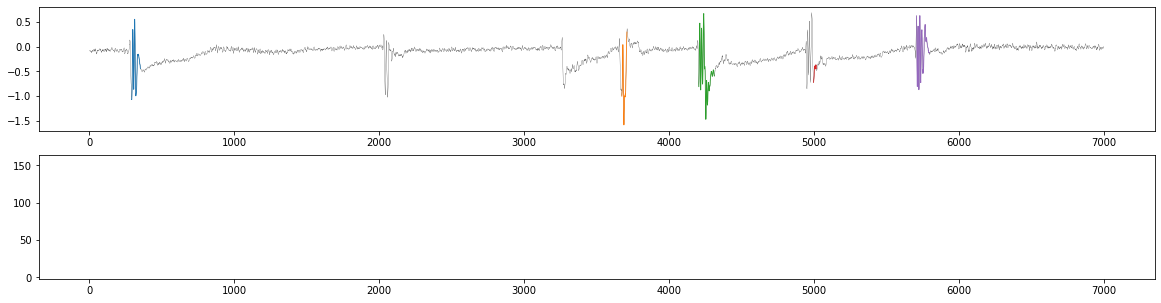

In [120]:
Duration = 700*10
IdSt = 300938# np.random.randint(tail_signal.shape[0]-Duration)
while True:
    IdSt = np.random.randint(tail_signal.shape[0]-Duration)
    id = np.where((bouts_onset>IdSt)&(bouts_onset<IdSt+Duration))[0]
    if len(id)>2:
        print(id)
        break

fig = plt.figure(figsize=(20,5))

s = tail.Reference_tail_segment_end
ax1 = plt.subplot(211)
ax1.plot(tail.angle_smooth[IdSt:IdSt+Duration,s],lw=.2,c='k')
#ax1.plot(tail_active[IdSt:IdSt+Duration])

on_ = bouts_onset[id]
off_ = bouts_offset[id]
on_,off_ = on_-IdSt,off_-IdSt

for i1,i2 in zip(on_,off_):
    ax1.plot(np.arange(i1,i2),tail.angle_smooth[IdSt+i1:IdSt+i2,s],lw=.8)

id = peaks[(peaks>IdSt)&(peaks<(IdSt+Duration))]-IdSt

ax2 = plt.subplot(212, sharex = ax1)
l = likelihood_ratio[(peaks>IdSt)&(peaks<(IdSt+Duration))]
if len(id)>2:
    ax2.plot(id,l,'*')
    ax2.hlines(Thresh,id[0],id[-1])

ax2.set_ylim(-2,Thresh*5)
plt.show()

# Compute DTW Distance with Core Bouts

In [99]:
import numpy as np
from scipy import signal

from tslearn import metrics

def dist_between_bouts(x_i,x_j,dtw_rad = 15,Normalized = False):
    x_i_sub,x_j_sub = make_same_lenght(x_i,x_j)
    if Normalized:
        power = np.sqrt(0.5*((np.max(x_i_sub)-np.min(x_i_sub))+(np.max(x_j_sub)-np.min(x_j_sub))))
    else:
        power = 1
    sim = metrics.dtw(x_i_sub, x_j_sub,global_constraint='sakoe_chiba',sakoe_chiba_radius=dtw_rad)
    return sim/(power)


def make_same_lenght(x,y):
    id_nan = np.where(np.isnan(x[:,0]))[0]
    d_x = id_nan[0] if len(id_nan) > 0 else x.shape[0]
    id_nan = np.where(np.isnan(y[:,0]))[0]
    d_y = id_nan[0] if len(id_nan) > 0 else y.shape[0]
    min_duration = min(d_x,d_y)
    x_sub = x[0:min_duration,:]
    y_sub = y[0:min_duration,:]
    return x_sub,y_sub

In [100]:
# Collect all bouts :
duration = [off_-on_ for on_,off_ in zip(bouts_onset,bouts_offset)]

NumBouts = len(bouts_onset)
MaxDuration = max(duration)
Margin = 20 # Bouts start 20 frame before onset
print(MaxDuration)

all_bouts = np.nan * np.ones((NumBouts,MaxDuration+Margin,tail.angle_smooth.shape[1]))

for i,(on_,off_) in enumerate(zip(bouts_onset,bouts_offset)):
    tmp = tail.angle_smooth[on_-Margin:off_,:]
    all_bouts[i,:tmp.shape[0],:] = tmp


218


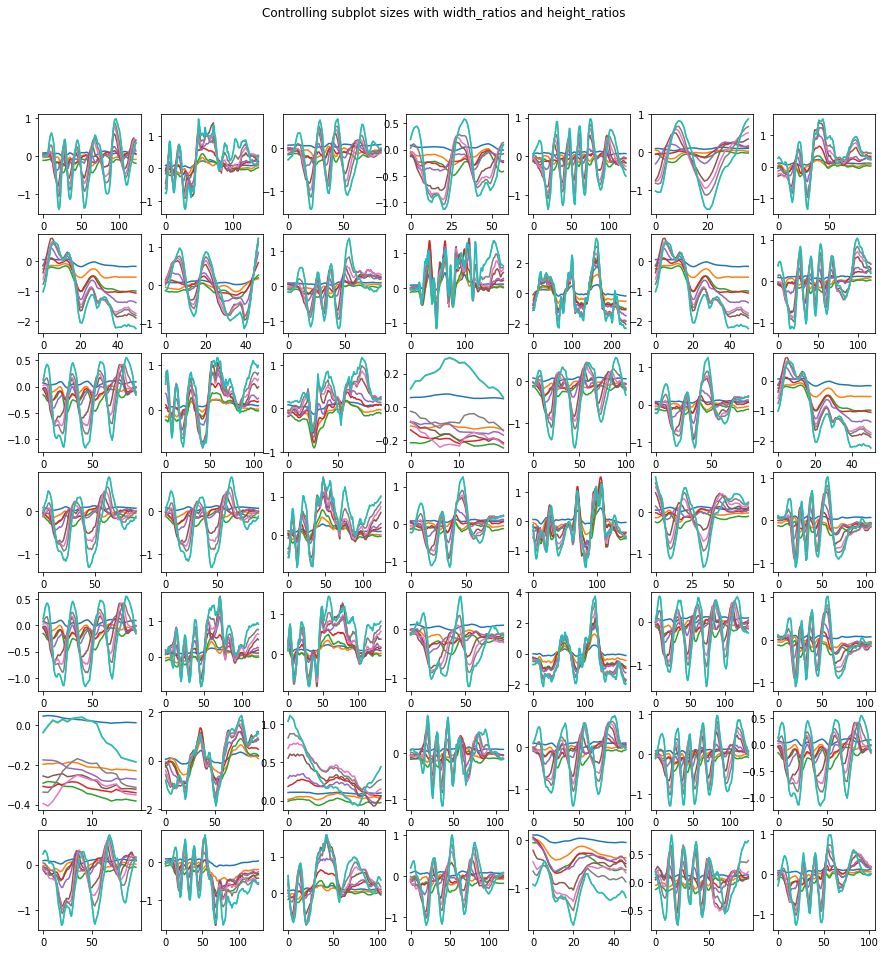

In [101]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,15))
fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")

gs = GridSpec(7, 7)
for i in range(7):
    for j in range(7):
        ax = fig.add_subplot(gs[i,j])
        k = np.random.randint(all_bouts.shape[0])
        ax.plot(all_bouts[k,:,:])
plt.show()

In [102]:
# Compute distance between bouts:
DistMatrix = np.zeros((NumBouts,NumBouts))
for i in range(NumBouts):
    for j in range(NumBouts):
        DistMatrix[i,j] = dist_between_bouts(all_bouts[i,:,:],all_bouts[j,:,:])


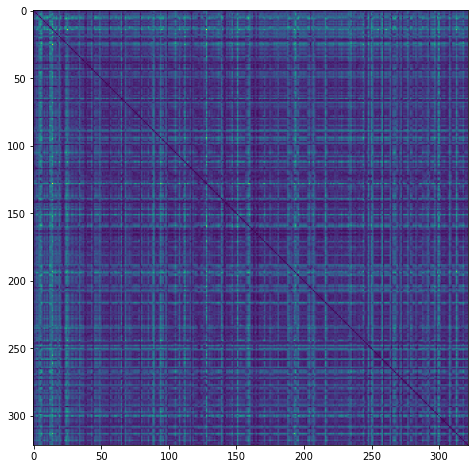

In [113]:
plt.figure(figsize=(8,8))
plt.imshow(DistMatrix)
plt.show()

In [121]:
A = DistMatrix
np.unravel_index(A[A>0].argmin(), A.shape)

(293, 15)

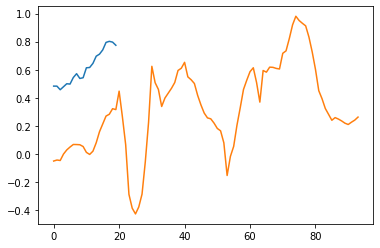

In [122]:
plt.plot(all_bouts[293,:,7])
plt.plot(all_bouts[15,:,7])